# Self-Driving Car Engineer Nanodegree


## Vehicle Detection Project

I have setup a ipython notebook to work on Vehicle Detection


## Import Packages

In [2]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import glob
import os
import random
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

%matplotlib inline

## Output Images

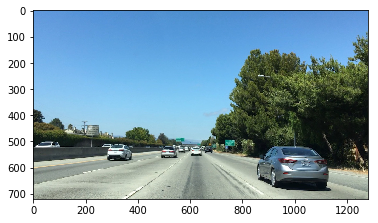

In [3]:
import os
#print(os.listdir("camera_cal/"))

test_image = mpimg.imread('./trial_images/bbox-example-image.jpg')

plt.imshow(test_image)
plt.show()


